In [1]:
import sys
sys.path.append('../../modelos/Pytorch-Age-Estimation-main')


In [2]:
import os
import dlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from random import randint
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.ticker import FuncFormatter


from predict import AgeEstimator 
import torch


C:\Users\lguzm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = AgeEstimator(weights = "../../modelos/weights.pt")

Weights loaded successfully from path: ../../modelos/weights.pt


In [4]:


# Configuración de las rutas a los directorios de imágenes
adults_path = '../../data/train/CLASE I, EDAD/ID_Adultos'
minors_path = '../../data/train/CLASE I, EDAD/ID_Menores_RevCM/'


In [5]:
def detectar_menor(image_path, age_threshold):
    # Suponiendo que 'model' es tu modelo cargado y configurado
    try:
        # Intenta obtener la predicción y convertirla a un ítem
        prob = model.predict(image_path).item()
        if prob < age_threshold:
            out = True
        else:
            out = False
    except Exception as e:
        # Maneja cualquier excepción que ocurra durante la predicción
        print(f"Error al procesar la imagen {image_path}: {str(e)}")
        # Establece out a False si hay una excepción, indicando que no se detectó un menor
        out = False

    return out



In [6]:

# Función para calcular métricas a diferentes edades de corte
def calculate_metrics(age_thresholds, cost_type_i, cost_type_ii):
    metrics = {age: {'FP': 0, 'FN': 0, 'TP': 0, 'TN': 0, 'Cost': 0} for age in age_thresholds}

    # Procesar imágenes de adultos
    for filename in os.listdir(adults_path):
        image_path = os.path.join(adults_path, filename)
        for age in age_thresholds:
            is_minor = detectar_menor(image_path, age)
            if is_minor:
                metrics[age]['FP'] += 1  # Error Tipo I: Adulto incorrectamente identificado como menor
            else:
                metrics[age]['TN'] += 1  # Correctamente identificado como adulto

    # Procesar imágenes de menores
    for filename in os.listdir(minors_path):
        image_path = os.path.join(minors_path, filename)
        for age in age_thresholds:
            is_minor = detectar_menor(image_path, age)
            if is_minor:
                metrics[age]['TP'] += 1  # Correctamente identificado como menor
            else:
                metrics[age]['FN'] += 1  # Error Tipo II: Menor incorrectamente identificado como adulto

    # Calcular costos y actualizar métricas
    for age in age_thresholds:
        metrics[age]['Cost'] = (metrics[age]['FP'] * cost_type_i) + (metrics[age]['FN'] * cost_type_ii)

    return metrics


In [7]:

# Parámetros configurables
thresholds = np.arange(10, 25)  # Edades de corte de 12 a 18 años


cost_type_i = 1100000*0.55
cost_type_ii = 250000

# Cálculo de métricas
metrics = calculate_metrics(thresholds, cost_type_i, cost_type_ii)

# Imprimir o procesar los resultados de las métricas
print(metrics)


Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported between instances of 'NoneType' and 'float'
Error al procesar la imagen ../../data/train/CLASE I, EDAD/ID_Menores_RevCM/ID_28.png: '>' not supported b

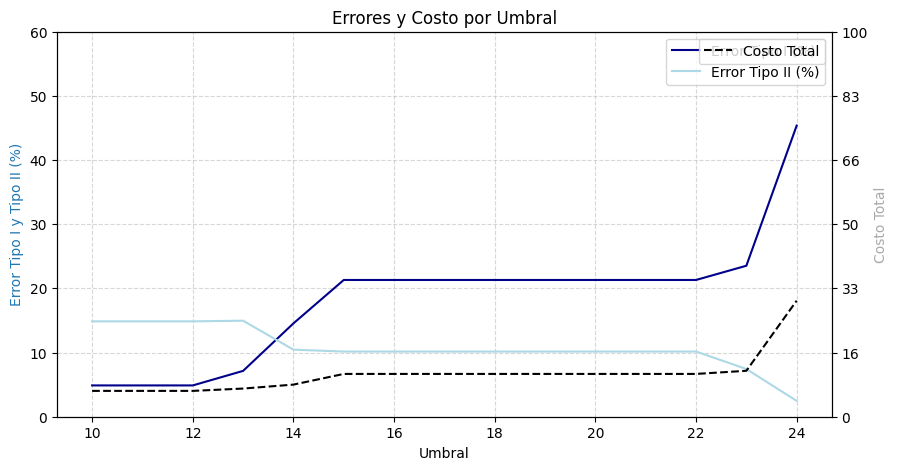

In [8]:
def int_formatter(x, pos):
    return f'{int(x/1e6)}'

# Errores y Costo por Umbral
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Umbral')
ax1.set_ylabel('Error Tipo I y Tipo II (%)', color='tab:blue')
ax1.plot(list(thresholds), [100 * metrics[t]['FP'] / (metrics[t]['FP'] + metrics[t]['TP']) if (metrics[t]['FP'] + metrics[t]['TP']) > 0 else 0 for t in thresholds], label='Error Tipo I (%)', color='darkblue')
ax1.plot(list(thresholds), [100 * metrics[t]['FN'] / (metrics[t]['FN'] + metrics[t]['TN']) if (metrics[t]['FN'] + metrics[t]['TN']) > 0 else 0 for t in thresholds], label='Error Tipo II (%)', color='lightblue')
ax1.set_ylim(bottom=0, top=60)
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Costo Total', color='darkgrey')
ax2.plot(list(thresholds), [metrics[t]['Cost'] for t in thresholds], label='Costo Total', color='black', linestyle='--')
ax2.set_ylim(bottom=0, top=1e8)
ax2.legend()

# Configurando grilla y ticks para que se alineen
ax1.grid(True, linestyle='--', which='both', axis='both', alpha=0.5)
ax1.set_yticks(np.linspace(0, 60, 7))  # 7 ticks en el eje primario
ax2.set_yticks(np.linspace(0, 1e8, 7))  # 7 ticks en el eje secundario para alinear con el primario
ax2.yaxis.set_major_formatter(FuncFormatter(int_formatter))

plt.title('Errores y Costo por Umbral')
plt.show()



